In [1]:
# ! pip install tensorflow==2.4.1
# ! pip install pandas
# ! pip install numpy

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

68606236/68606236 [==============================] - 0s 0us/step


In [7]:
!apt install file
!apt install -y imagemagick
!file /root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.199.jpg
!identify /root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.199.jpg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1
The following NEW packages will be installed:
  file libmagic-mgc libmagic1
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 275 kB of archives.
After this operation, 5,297 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic1 amd64 1:5.32-2ubuntu0.4 [68.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 file amd64 1:5.32-2ubuntu0.4 [22.1 kB]
Fetched 275 kB in 1s (299 kB/s)
Selecting previously unselected package libmagic-mgc.
(Reading database ... 124016 files and 

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
data_augmentation = tf.keras.Sequential([
  # A preprocessing layer which randomly flips images during training.
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  # A preprocessing layer which randomly rotates images during training.
  tf.keras.layers.RandomRotation(0.2),
])

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
# 32 images, since our batch_size is 32
print(feature_batch.shape)

9406464/9406464 [==============================] - 0s 0us/step
(32, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
# (32, 5, 5, 1280) -> (32, 1280)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 61s 900ms/step - loss: 0.7494 - accuracy: 0.5665 - val_loss: 0.5859 - val_accuracy: 0.6980
Epoch 2/10
63/63 [==============================] - 58s 900ms/step - loss: 0.5853 - accuracy: 0.6675 - val_loss: 0.4395 - val_accuracy: 0.7958
Epoch 3/10
63/63 [==============================] - 56s 882ms/step - loss: 0.5228 - accuracy: 0.7240 - val_loss: 0.3484 - val_accuracy: 0.8342
Epoch 4/10
63/63 [==============================] - 59s 928ms/step - loss: 0.4362 - accuracy: 0.7855 - val_loss: 0.2993 - val_accuracy: 0.8626
Epoch 5/10
63/63 [==============================] - 57s 900ms/step - loss: 0.4136 - accuracy: 0.7995 - val_loss: 0.2609 - val_accuracy: 0.8874
Epoch 6/10
63/63 [==============================] - 56s 883ms/step - loss: 0.3860 - accuracy: 0.8145 - val_loss: 0.2357 - val_accuracy: 0.8973
Epoch 7/10
63/63 [==============================] - 57s 905ms/step - loss: 0.3647 - accuracy: 0.8305 - val_loss: 0.2153 - val_accuracy: 0.9109

In [19]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [21]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 92s 1s/step - loss: 0.2501 - accuracy: 0.8845 - val_loss: 0.0828 - val_accuracy: 0.9740
Epoch 11/20
63/63 [==============================] - 81s 1s/step - loss: 0.1977 - accuracy: 0.9115 - val_loss: 0.0672 - val_accuracy: 0.9752
Epoch 12/20
63/63 [==============================] - 83s 1s/step - loss: 0.1689 - accuracy: 0.9250 - val_loss: 0.0823 - val_accuracy: 0.9691
Epoch 13/20
63/63 [==============================] - 82s 1s/step - loss: 0.1557 - accuracy: 0.9400 - val_loss: 0.0640 - val_accuracy: 0.9777
Epoch 14/20
63/63 [==============================] - 80s 1s/step - loss: 0.1588 - accuracy: 0.9365 - val_loss: 0.0791 - val_accuracy: 0.9703
Epoch 15/20
63/63 [==============================] - 82s 1s/step - loss: 0.1518 - accuracy: 0.9375 - val_loss: 0.0566 - val_accuracy: 0.9777
Epoch 16/20
63/63 [==============================] - 79s 1s/step - loss: 0.1380 - accuracy: 0.9395 - val_loss: 0.0569 - val_accuracy: 0.9777
Epoch 17/20
6

Predictions:
 [1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0]
Labels:
 [1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0]


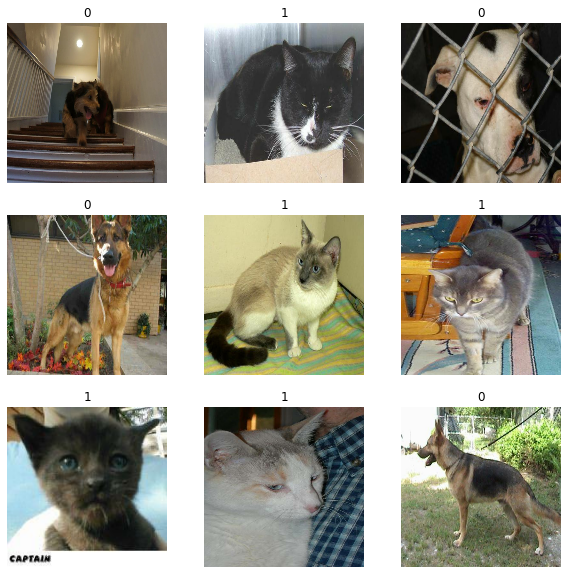

In [26]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(label_batch[predictions[i]])
  plt.axis("off")